In [1]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# We call the csv data
df = pd.read_csv('../../../../data/raw/winequalityN.csv')
# We fill the NaN numerical values with 0
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# White wine
dfW = df[df['type'] == 'white']
dfW = dfW.drop('type', axis=1)

### Remove the following code chunk if not condensing output classes into three classes for quality

In [3]:
# Convert the target variable 'quality' to categorical classes since the prediction score is low when using all 6 outputs.
# The function will map quality scores 'low', 'medium', 'high' if they fall within the range from 0-4, 5-7 and 8+ respectively
def categorize_quality(row):
    if row <= 4:
        return 'low'
    elif 5 <= row <= 7:
        return 'medium'
    else:
        return 'high'

# Applying the function to the quality column so we sort into three categories rather than 6 (remember from EDA that we originally 
# only had 6 outputs due to scores that were not given)
dfW['quality'] = dfW['quality'].apply(categorize_quality)

### Let's incorporate Gridsearch into the funtion as well. 

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
# Goal: define a function for getting mettrics from an SVM model so we can apply it to datasets with certain features removed based on 
# collinearity we identified in EDA

# We will also add the option for grid search for c and gamma hyperparameters
# We have selected radial basis function kernel based on our literature review and our data's non-linear nature. 

def get_SVM_Metrics(dataframe, param_grid=None, scale_features=True):
    # Our target variable is wine quality 
    y = dataframe['quality']
    X = dataframe.drop('quality', axis=1)
    
    # We split the data into training and testing. Between models, we have elected a test size of 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features is default to true
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Create a SVM Classifier
    classifier = svm.SVC(kernel='rbf') # Radial Basis Function Kernel

    # Perform GridSearchCV if a parameter grid is provided
    if param_grid:
        # Between models, we have elected to utilize 5 folds for cross validation
        grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=1, n_jobs=-1)
        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train) 
        # .best_params_ returns a dictionary of the best parameters
        print(f"Best parameters found: {grid_search.best_params_}")
        # .best_estimator_ returns the object of the model using the best parameters 
        classifier = grid_search.best_estimator_
    else:
        # Otherwide, the model should be trained on the training set specialized initially
        classifier.fit(X_train, y_train)
    
    # Predict the response for the test dataset
    y_pred = classifier.predict(X_test)
    
    # NEXT we want to calculate the metrics: accuracy, precision, recall, and F1 score
    # Precision: The proportion of true positive predictions out of all the predicted positives (true positives + false positives)
    # Recall: The proportion of true positive predictions out of all the actual positives (true positives + false negatives).
    # f1 score: The harmonic mean of precision and recall, which balances the two and is particularly useful when you want to account 
    # for both false positives and false negatives.
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Return the metrics
    return accuracy, precision, recall, f1

In [6]:
metrics_scores = {}
features_dropped = {}

In [7]:
# Define the parameter grid for hyperparameter tuning
# Note that we previously experimented with 'C': [0.1, 1, 10, 100, 1000] and later 'C': [7, 8, 9, 10, 11]
# Since both resulted in 11 as the best parameter for C, we are leaving this list here for the report

# For gamma, note that:
# 'scale' corresponds to 1/(n_features * X.var()) , 
# 'auto' correponds to 1/n_features (this is the default for grid search)
# 0.1 is a relatively small value of gamma. Small values result in smoother decision boundaries. 
# 1 is a higher value for gamma but is not quite large. Large values result in more erratic decision boundaries and can lead to overfitting
# in all instances tested below, gamma:1 has had the best performance

param_grid = {
    'C': [11, 12, 13, 14, 15], 
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [8]:
dfW.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Using all Features

In [9]:
# Get the evaluation metrics using all features
metrics = get_SVM_Metrics(dfW, param_grid = param_grid, scale_features=True)

# Print the evaluation metrics
print(f"Model metrics: {metrics}")
# Add the evaluation metrics to our dictionary for plotting
metrics_scores["None"] = metrics 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 11, 'gamma': 1}
Accuracy: 0.9459
Precision: 0.9338
Recall: 0.9459
F1 Score: 0.9341
Model metrics: (0.9459183673469388, np.float64(0.9337716218562897), np.float64(0.9459183673469388), np.float64(0.9340807381107771))


### Without Residual Sugar

In [10]:
# Get the evaluation metrics without residual sugar in the df
dfW_no_residual_sugar = dfW.drop(columns=['residual sugar'])

metrics = get_SVM_Metrics(dfW_no_residual_sugar, param_grid = param_grid, scale_features=True)

# Print the evaluation metrics
print(f"Model metrics: {metrics}")
# Add the evaluation metrics to our dictionary for plotting
metrics_scores["Residual Sugar"] = metrics 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 11, 'gamma': 1}
Accuracy: 0.9459
Precision: 0.9338
Recall: 0.9459
F1 Score: 0.9341
Model metrics: (0.9459183673469388, np.float64(0.9337716218562897), np.float64(0.9459183673469388), np.float64(0.9340807381107771))


In [11]:
# Checking that the desired feature was dropped has been dropped given that they have the exact same metrics. 
# It appears that the feature was dropped so our model likely doesn't consider it in its prediction. 
dfW_no_residual_sugar.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Without Density

In [12]:
# Get the evaluation metrics without density
dfW_no_density = dfW.drop(columns=['density'])

metrics = get_SVM_Metrics(dfW_no_density, param_grid = param_grid, scale_features=True)

# Print the evaluation metrics
print(f"Model metrics: {metrics}")
# Add the evaluation metrics to our dictionary for plotting
metrics_scores["Density"] = metrics 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 11, 'gamma': 1}
Accuracy: 0.9449
Precision: 0.9324
Recall: 0.9449
F1 Score: 0.9334
Model metrics: (0.9448979591836735, np.float64(0.932363837455234), np.float64(0.9448979591836735), np.float64(0.9334097532935098))


### Without Alchohol

In [13]:
# Get the evaluation metrics without alcohol 
dfW_no_alcohol =  dfW.drop(columns=['alcohol'])

metrics = get_SVM_Metrics(dfW_no_alcohol, param_grid = param_grid, scale_features=True)

# Print the evaluation metrics
print(f"Model metrics: {metrics}")
# Add the evaluation metrics to our dictionary for plotting
metrics_scores["Alcohol"] = metrics 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 11, 'gamma': 1}
Accuracy: 0.9418
Precision: 0.9276
Recall: 0.9418
F1 Score: 0.9302
Model metrics: (0.9418367346938775, np.float64(0.9276009213209092), np.float64(0.9418367346938775), np.float64(0.9301585468297131))


### Plot 

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Checking the contents of our dictionary 
print(metrics_scores)

{'None': (0.9459183673469388, np.float64(0.9337716218562897), np.float64(0.9459183673469388), np.float64(0.9340807381107771)), 'Residual Sugar': (0.9459183673469388, np.float64(0.9337716218562897), np.float64(0.9459183673469388), np.float64(0.9340807381107771)), 'Density': (0.9448979591836735, np.float64(0.932363837455234), np.float64(0.9448979591836735), np.float64(0.9334097532935098)), 'Alcohol': (0.9418367346938775, np.float64(0.9276009213209092), np.float64(0.9418367346938775), np.float64(0.9301585468297131))}


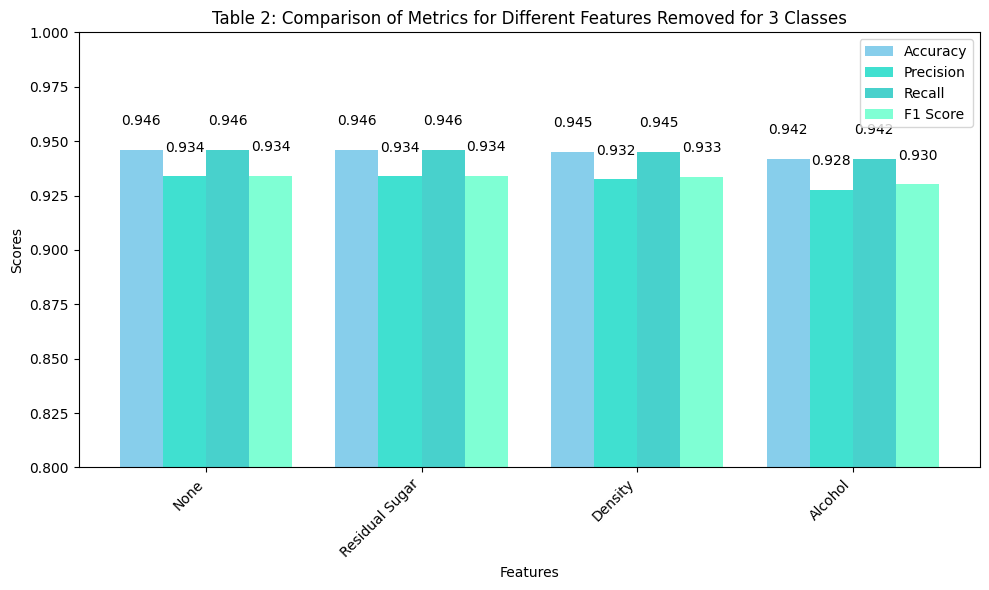

In [16]:
# Extracting keys (features) and the corresponding metrics 
features = list(metrics_scores.keys())
metrics = np.array(list(metrics_scores.values()))

# Extracting individual metrics (accuracy, precision, recall, F1)
accuracy_scores = metrics[:, 0]
precision_scores = metrics[:, 1]
recall_scores = metrics[:, 2]
f1_scores = metrics[:, 3]

# Set up the bar plot width and positions
x = np.arange(len(features))  # positions for the bars
width = 0.2  # the width of the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric (accuracy, precision, recall, F1)
bars1 = ax.bar(x - width * 1.5, accuracy_scores, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x - width * 0.5, precision_scores, width, label='Precision', color='turquoise')
bars3 = ax.bar(x + width * 0.5, recall_scores, width, label='Recall', color='mediumturquoise')
bars4 = ax.bar(x + width * 1.5, f1_scores, width, label='F1 Score', color='aquamarine')

# Add labels, title, and custom x-axis ticks
ax.set_xlabel('Features')
ax.set_ylabel('Scores')
ax.set_title('Table 2: Comparison of Metrics for Different Features Removed for 3 Classes')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha="right")

# Adjust the range of y so it is easier to visualize the differences between bars
ax.set_ylim(0.8, 1)

# Add values on top of the bars using the values from metrics_scores
for i, feature in enumerate(features):
    accuracy = metrics_scores[feature][0]
    precision = metrics_scores[feature][1]
    recall = metrics_scores[feature][2]
    f1 = metrics_scores[feature][3]

    # Adding text labels above each bar for each metric
    ax.text(x[i] - width * 1.5, accuracy + 0.01, f'{accuracy:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] - width * 0.5, precision + 0.01, f'{precision:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width * 0.5, recall + 0.01, f'{recall:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width * 1.5, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [17]:
metrics_scores["None"] == metrics_scores["Residual Sugar"]

True

### When using all outputs, the accuracy was highest when we removed density. When we consolidated all classes, though, this reduced the effect of removing it on performance. Let's run this again calculating all metric scores and all ouput classes (6 total)

In [18]:
# We call the csv data
df2 = pd.read_csv('../../../..//data/raw/winequalityN.csv')
# We fill the NaN numerical values with 0
df2.fillna(df2.select_dtypes(include='number').mean(), inplace=True)

# White wine
dfW2 = df2[df['type'] == 'white']
dfW2 = dfW2.drop('type', axis=1)

In [19]:
metrics_scores2 = {}
features_dropped2 = {}

In [20]:
# Get the metrics using all features
metrics2 = get_SVM_Metrics(dfW2, param_grid = param_grid, scale_features=True)

# Print the metrics
print(f"Model metrics: {metrics2}")
metrics_scores2["None"] = metrics2 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 12, 'gamma': 1}
Accuracy: 0.6633
Precision: 0.6758
Recall: 0.6633
F1 Score: 0.6552
Model metrics: (0.6632653061224489, np.float64(0.6757540890598495), np.float64(0.6632653061224489), np.float64(0.6552414323272256))


In [21]:
# Get the metrics using without residual sugar 
dfW_no_residual_sugar2 = dfW2.drop(columns=['residual sugar'])

metrics2 = get_SVM_Metrics(dfW_no_residual_sugar2, param_grid = param_grid, scale_features=True)

# Print the metrics
print(f"Model metrics: {metrics2}")
metrics_scores2["Residual Sugar"] = metrics2 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 12, 'gamma': 1}
Accuracy: 0.6673
Precision: 0.6762
Recall: 0.6673
F1 Score: 0.6596
Model metrics: (0.6673469387755102, np.float64(0.6761662300845805), np.float64(0.6673469387755102), np.float64(0.659567745105431))


In [22]:
# Get the metrics using without density 
dfW_no_density2 = dfW2.drop(columns=['density'])

metrics2 = get_SVM_Metrics(dfW_no_density2, param_grid = param_grid, scale_features=True)

# Print the metrics
print(f"Model metrics: {metrics2}")
metrics_scores2["Density"] = metrics2 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 14, 'gamma': 1}
Accuracy: 0.6735
Precision: 0.6847
Recall: 0.6735
F1 Score: 0.6654
Model metrics: (0.673469387755102, np.float64(0.6846902906617192), np.float64(0.673469387755102), np.float64(0.6654267189594786))


In [23]:
# Get the metrics using without alcohol 
dfW_no_alcohol2 =  dfW2.drop(columns=['alcohol'])

metrics2 = get_SVM_Metrics(dfW_no_alcohol2, param_grid = param_grid, scale_features=True)

# Print the metrics
print(f"Model metrics: {metrics2}")
metrics_scores2["Alcohol"] = metrics2

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 13, 'gamma': 1}
Accuracy: 0.6531
Precision: 0.6626
Recall: 0.6531
F1 Score: 0.6452
Model metrics: (0.6530612244897959, np.float64(0.6625730292116846), np.float64(0.6530612244897959), np.float64(0.6451990820515883))


In [24]:
print(metrics_scores2)

{'None': (0.6632653061224489, np.float64(0.6757540890598495), np.float64(0.6632653061224489), np.float64(0.6552414323272256)), 'Residual Sugar': (0.6673469387755102, np.float64(0.6761662300845805), np.float64(0.6673469387755102), np.float64(0.659567745105431)), 'Density': (0.673469387755102, np.float64(0.6846902906617192), np.float64(0.673469387755102), np.float64(0.6654267189594786)), 'Alcohol': (0.6530612244897959, np.float64(0.6625730292116846), np.float64(0.6530612244897959), np.float64(0.6451990820515883))}


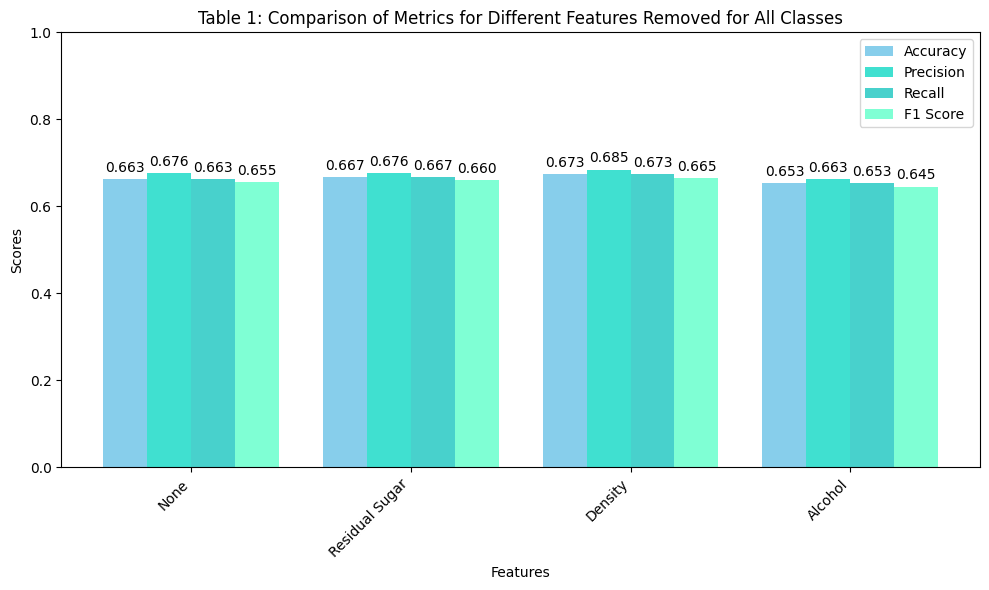

In [25]:
# Extracting keys (features) and the corresponding metric values
features2 = list(metrics_scores2.keys())
metrics2 = np.array(list(metrics_scores2.values()))

# Extracting individual metrics (accuracy, precision, recall, F1)
accuracy_scores2 = metrics2[:, 0]
precision_scores2 = metrics2[:, 1]
recall_scores2 = metrics2[:, 2]
f1_scores2 = metrics2[:, 3]

# Set up the bar plot width and positions
x = np.arange(len(features))  # positions for the bars
width = 0.2  # the width of the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric (accuracy, precision, recall, F1)
bars1_2 = ax.bar(x - width * 1.5, accuracy_scores2, width, label='Accuracy', color='skyblue')
bars2_2 = ax.bar(x - width * 0.5, precision_scores2, width, label='Precision', color='turquoise')
bars3_2 = ax.bar(x + width * 0.5, recall_scores2, width, label='Recall', color='mediumturquoise')
bars4_2 = ax.bar(x + width * 1.5, f1_scores2, width, label='F1 Score', color='aquamarine')

# Add labels, title, and custom x-axis ticks
ax.set_xlabel('Features')
ax.set_ylabel('Scores')
ax.set_title('Table 1: Comparison of Metrics for Different Features Removed for All Classes')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha="right")

#adjust range of y visualized
ax.set_ylim(0, 1)

# Add values on top of the bars using the values from metrics_scores
for i, feature in enumerate(features2):
    accuracy2 = metrics_scores2[feature][0]
    precision2 = metrics_scores2[feature][1]
    recall2 = metrics_scores2[feature][2]
    f12 = metrics_scores2[feature][3]

    # Adding text labels above each bar for each metric
    ax.text(x[i] - width * 1.5, accuracy2 + 0.01, f'{accuracy2:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] - width * 0.5, precision2 + 0.01, f'{precision2:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width * 0.5, recall2 + 0.01, f'{recall2:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width * 1.5, f12 + 0.01, f'{f12:.3f}', ha='center', va='bottom', fontsize=10)

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

### As before, we see that when density is removed, the model performs better than for all other features removed 

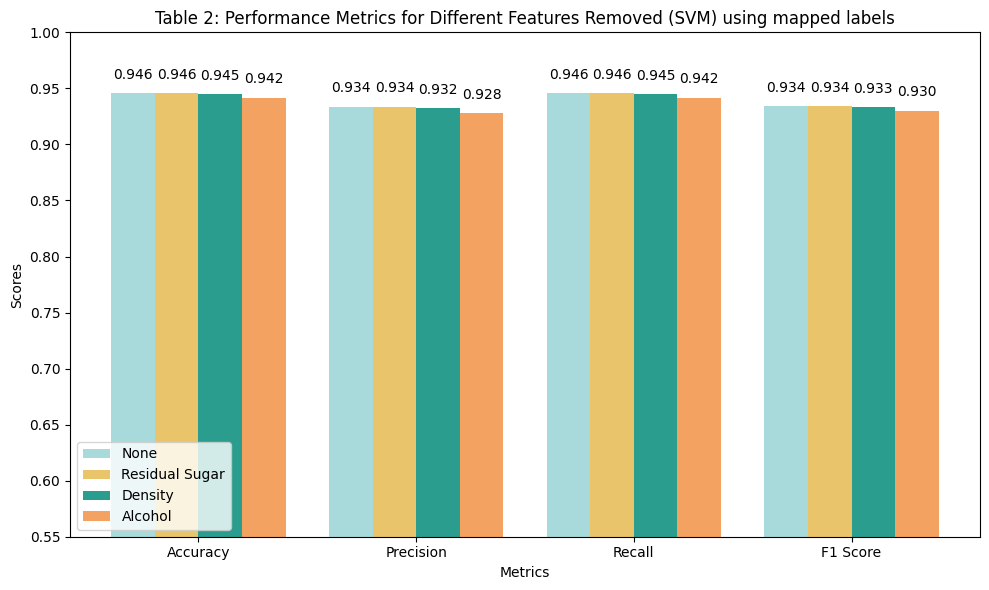

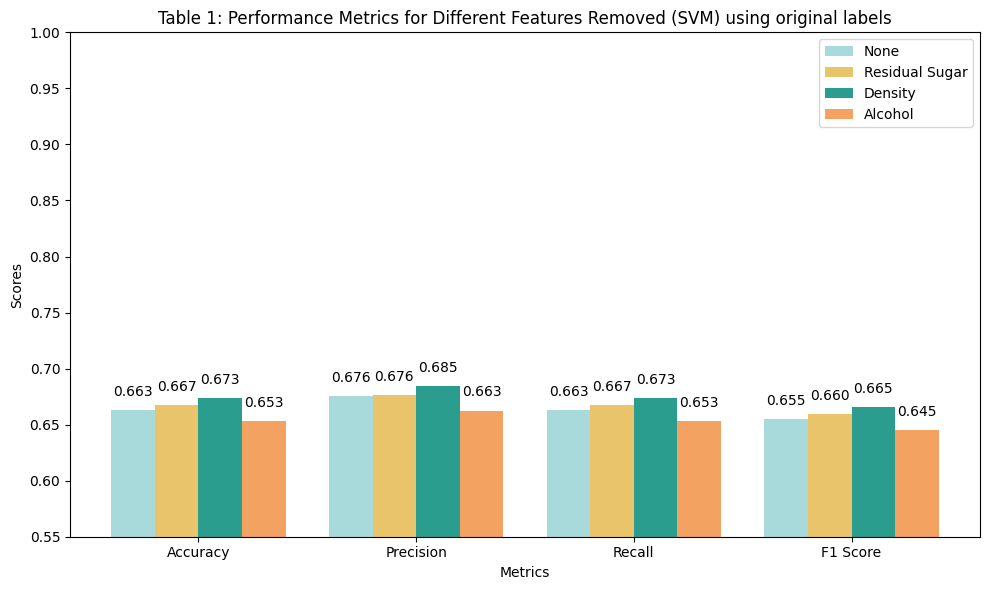

In [27]:
# Define colors
colors = ['#a8dadc',   # Light blue
          '#e9c46a',   # Muted yellow
          '#2a9d8f',   # Teal
          '#f4a261']   # Soft orange

# For the 3-classes approach
# Extracting data from metrics_scores dictionary
features = list(metrics_scores.keys())
metrics = np.array(list(metrics_scores.values()))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define metrics labels and positions
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metric_labels))
width = 0.2

# Plot bars for each feature
for i, feature in enumerate(features):
    offset = width * (i - len(features)/2 + 0.5)
    bars = ax.bar(x + offset, metrics_scores[feature], width, 
                 label=feature, color=colors[i])
    
    # Add value labels on top of bars
    for j, v in enumerate(metrics_scores[feature]):
        ax.text(x[j] + offset, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Table 2: Performance Metrics for Different Features Removed (SVM) using mapped labels')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0.55, 1)  # Adjust as needed
ax.legend()

plt.tight_layout()
plt.savefig('../../../data/eval_results/SVM_features_removed.png', dpi=300, bbox_inches='tight')
plt.show()

# For all-classes approach
# Create second figure for all-classes results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each feature
for i, feature in enumerate(features):
    offset = width * (i - len(features)/2 + 0.5)
    bars = ax.bar(x + offset, metrics_scores2[feature], width, 
                 label=feature, color=colors[i])
    
    # Add value labels on top of bars
    for j, v in enumerate(metrics_scores2[feature]):
        ax.text(x[j] + offset, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Table 1: Performance Metrics for Different Features Removed (SVM) using original labels')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0.55, 1)  # Adjusted for all-classes approach
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig('../../../data/eval_results/SVM_features_removed_original_labels.png', dpi=300, bbox_inches='tight')
plt.show()